# Modelling the DEZEMBER Alternation

In this notebook, the DEZEMBER alternation is modelled as described in the doctoral thesis. Refer to the relevant chapter to understand modelling choices.

Note that in this notebook, the variable for the logarithmised distance is called PREVIOUS_DISTANCE_LOG, whereas it is simply called PREVIOUS_DISTANCE in the doctoral thesis. Despite lacking the specifier "_LOG" in the thesis, the variables in the formulae always refer to the logarithmised version of the distance measure.

## Preparations

### Installing and Importing Relevant Libraries

In [ ]:
install.packages(c("lme4", "glue", "performance", "rstudioapi", "broom", "scales", 
                   "sjPlot", "ggplot2", "dplyr", "stargazer", "broom.mixed", "car"))

In [1]:
library(lme4)
library(glue)
library(performance)
library(rstudioapi)
library(broom)
library(scales)
library(sjPlot)
library(ggplot2)
library(dplyr)
library(stargazer)
library(broom.mixed)

Lade nötiges Paket: Matrix


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




### Loading and Preprocessing Data

In [2]:
data <- read.csv("dezember_zwoelf_for_modelling.csv")

Treatment coding of response variable: "dezember" = 0, "zwölf" = 1.

In [3]:
data <- read.csv("dezember_zwoelf_for_modelling.csv")
data$CURRENT <- as.factor(data$CURRENT)
cat("R models this level:", tail(levels(data$CURRENT), 1))

R models this level: zwoelf

Renaming speakers for consistency with the rest of the thesis.

In [4]:
data <- data %>% mutate(PREVIOUS_SPEAKER = recode(PREVIOUS_SPEAKER, "A" = "VA", "S" = "HS"))

Combining the variables PREVIOUS and PREVIOUS_SPEAKER, as modelling an interaction of these two independent variables leads to an issue of singularity.

In [5]:
data$PREVIOUS_SPEAKER_COMBINED <- interaction(data$PREVIOUS, data$PREVIOUS_SPEAKER) #R automatically creates a factor
cat("Levels are:", levels(data$PREVIOUS_SPEAKER_COMBINED))

Levels are: dezember.HS zwoelf.HS dezember.VA zwoelf.VA

`interaction()` also creates combinations which never appear. 

In [6]:
#discarding empty levels
data$PREVIOUS_SPEAKER_COMBINED <- droplevels(data$PREVIOUS_SPEAKER_COMBINED)

#before renaming (see above) "dezember.A" was the reference level as it is first in alphabetical order, 
#to preserve this even after renaming, the factor is relevelled 
data$PREVIOUS_SPEAKER_COMBINED <- relevel(data$PREVIOUS_SPEAKER_COMBINED, ref = "dezember.VA")
cat("The reference level of PREVIOUS_SPEAKER_COMBINED is:", head(levels(data$PREVIOUS_SPEAKER_COMBINED), 1)) 

The reference level of PREVIOUS_SPEAKER_COMBINED is: dezember.VA

Treatment coding of further predictor variables.

In [7]:
data <- data %>% rename(PREVIOUS_BETA_ZWOELF = PREVIOUS_BETA_ZWÖLF) #renaming to avoid Umlaut issue
data$PREVIOUS_BETA_ZWOELF <- as.factor(data$PREVIOUS_BETA_ZWOELF) 
data$QUASI_PERSISTENCE <- as.factor(data$QUASI_PERSISTENCE) 
data$CONFEDERATE <- as.factor(data$CONFEDERATE) 

## Simple Model

### Model Fitting

Fitting a simple regression model without any random effects to assess how the predictor variables impact the response variable.

In [8]:
simple_model <- glm(CURRENT ~ PREVIOUS_SPEAKER_COMBINED * PREVIOUS_DISTANCE_LOG + 
                                     PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE +
                                     PREVIOUS_BETA_ZWOELF,
                                     data = data, family = 'binomial')

summary(simple_model)


Call:
glm(formula = CURRENT ~ PREVIOUS_SPEAKER_COMBINED * PREVIOUS_DISTANCE_LOG + 
    PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE + PREVIOUS_BETA_ZWOELF, 
    family = "binomial", data = data)

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                                  3.3034     0.9621
PREVIOUS_SPEAKER_COMBINEDdezember.HS                        -7.1684     1.9489
PREVIOUS_SPEAKER_COMBINEDzwoelf.HS                          -1.7894     2.1151
PREVIOUS_DISTANCE_LOG                                       -0.4313     0.2147
QUASI_PERSISTENCETrue                                       -0.2154     0.3114
PREVIOUS_BETA_ZWOELFTrue                                    -0.5477     0.2448
PREVIOUS_SPEAKER_COMBINEDdezember.HS:PREVIOUS_DISTANCE_LOG   1.1119     0.5053
PREVIOUS_SPEAKER_COMBINEDzwoelf.HS:PREVIOUS_DISTANCE_LOG     1.2250     0.7179
PREVIOUS_SPEAKER_COMBINEDdezember.HS:QUASI_PERSISTENCETrue   1.5377     0.886

### Model Evaluation

#### R² and AIC

In [9]:
r2_nagelkerke(simple_model)
AIC(simple_model)

Nagelkerke's R2 
      0.2783547

[1] 554.7004

#### Predictive Efficiency

In [10]:
#Predicting based on simple_model
fixed_model_predictions <- predict(simple_model, newdata = data, type = "response")
#Convert probabilities to binary outcomes (i.e., if probability > 0.5, predict 1, else 0)
fixed_model_predicted_class <- ifelse(fixed_model_predictions > 0.5, "zwoelf", "dezember")
#Compare predicted values to actual values
fixed_model_accuracy <- mean(fixed_model_predicted_class == data$CURRENT)
fixed_model_accuracy

[1] 0.8442136

In [11]:
#Calculate baseline accuracy, i.e., a dumb intercept-only model only ever predicting the most frequent outcome
counts <- table(data$CURRENT) 
dumb_model_accuracy <- max(counts) / sum(counts)
dumb_model_accuracy

[1] 0.805638

In [12]:
#McNemar's Test for significance against baseline
baseline_predicted_class <- rep(names(which.max(counts)), length(data$CURRENT))  #Create baseline predictions (always predict the most frequent outcome)
mcnemar_table <- table(
  model_correct = (fixed_model_predicted_class == data$CURRENT),
  baseline_correct = (baseline_predicted_class == data$CURRENT)) #Create a contingency table: Compare model and baseline predictions against actual values
mcnemar_result <- mcnemar.test(mcnemar_table) #Perform McNemar's Test
mcnemar_result


	McNemar's Chi-squared test with continuity correction

data:  mcnemar_table
McNemar's chi-squared = 14.881, df = 1, p-value = 0.0001145


## Mixed Model

### Model Fitting

In [13]:
initial_mixed_model <- glmer(CURRENT ~ PREVIOUS_SPEAKER_COMBINED * PREVIOUS_DISTANCE_LOG + 
                                      PREVIOUS_BETA_ZWOELF +
                                      (1 | HUMAN_ID), 
                                      data = data, family = binomial)

summary(initial_mixed_model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: CURRENT ~ PREVIOUS_SPEAKER_COMBINED * PREVIOUS_DISTANCE_LOG +  
    PREVIOUS_BETA_ZWOELF + (1 | HUMAN_ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   317.6    353.7   -150.8    301.6      666 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.7382  0.0224  0.0541  0.1445  4.1599 

Random effects:
 Groups   Name        Variance Std.Dev.
 HUMAN_ID (Intercept) 15.98    3.998   
Number of obs: 674, groups:  HUMAN_ID, 27

Fixed effects:
                                                           Estimate Std. Error
(Intercept)                                                 5.59624    1.56626
PREVIOUS_SPEAKER_COMBINEDdezember.HS                       -5.78328    2.14478
PREVIOUS_SPEAKER_COMBINEDzwoelf.HS                         -0.02319    2.15566
PREVIOUS_DISTANCE_LOG                                      -0.37706    0.27502
PRE

In [14]:
final_mixed_model <- glmer(CURRENT ~ PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE +
                                         PREVIOUS_BETA_ZWOELF + 
                                         (1 | HUMAN_ID), 
                                         data = data, family = binomial)

summary(final_mixed_model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
CURRENT ~ PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE + PREVIOUS_BETA_ZWOELF +  
    (1 | HUMAN_ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   319.0    355.1   -151.5    303.0      666 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.6795  0.0241  0.0585  0.1560  3.3787 

Random effects:
 Groups   Name        Variance Std.Dev.
 HUMAN_ID (Intercept) 15.94    3.993   
Number of obs: 674, groups:  HUMAN_ID, 27

Fixed effects:
                                                           Estimate Std. Error
(Intercept)                                                 3.80135    1.15255
PREVIOUS_SPEAKER_COMBINEDdezember.HS                       -1.82305    0.67443
PREVIOUS_SPEAKER_COMBINEDzwoelf.HS                          1.81047    0.70069
QUASI_PERSISTENCETrue                                       0.53231    0.39863
PREVIO

### Model evaluation

#### R² and AIC

In [15]:
r2(initial_mixed_model)
AIC(initial_mixed_model)

r2(final_mixed_model)
AIC(final_mixed_model)

# R2 for Mixed Models

  Conditional R2: 0.841
     Marginal R2: 0.068

[1] 317.5529

# R2 for Mixed Models

  Conditional R2: 0.840
     Marginal R2: 0.067

[1] 319.0295

#### Predictive Efficiency

In [16]:
#Predicting based on final_mixed_model
mixed_model_predictions <- predict(final_mixed_model, newdata = data, type = "response")
#Convert probabilities to binary outcomes (i.e., if probability > 0.5, predict 1, else 0)
mixed_model_predicted_class <- ifelse(mixed_model_predictions > 0.5, "zwoelf", "dezember")
#Compare predicted values to actual values
mixed_model_accuracy <- mean(mixed_model_predicted_class == data$CURRENT)
mixed_model_accuracy

[1] 0.9332344

In [17]:
#Calculate baseline accuracy, i.e., a dumb intercept-only model only ever predicting the most frequent outcome
counts <- table(data$CURRENT) 
dumb_model_accuracy <- max(counts) / sum(counts)
dumb_model_accuracy

[1] 0.805638

In [18]:
#McNemar's Test for significance against baseline
baseline_predicted_class <- rep(names(which.max(counts)), length(data$CURRENT))  #Create baseline predictions (always predict the most frequent outcome)
mcnemar_table <- table(
  model_correct = (mixed_model_predicted_class == data$CURRENT),
  baseline_correct = (baseline_predicted_class == data$CURRENT)) #Create a contingency table: Compare model and baseline predictions against actual values
mcnemar_result <- mcnemar.test(mcnemar_table) #Perform McNemar's Test
mcnemar_result


	McNemar's Chi-squared test with continuity correction

data:  mcnemar_table
McNemar's chi-squared = 62.284, df = 1, p-value = 2.973e-15


In [19]:
#McNemar's Test for significance against fixed effects model
baseline_predicted_class <- rep(names(which.max(counts)), length(data$CURRENT))  #Create baseline predictions (always predict the most frequent outcome)
mcnemar_table <- table(
  mixed_model_correct = (mixed_model_predicted_class == data$CURRENT),
  fixed_model_correct = (fixed_model_predicted_class == data$CURRENT)) #Create a contingency table: Compare model and baseline predictions against actual values
mcnemar_result <- mcnemar.test(mcnemar_table) #Perform McNemar's Test
mcnemar_result


	McNemar's Chi-squared test with continuity correction

data:  mcnemar_table
McNemar's chi-squared = 42.451, df = 1, p-value = 7.247e-11


#### Multicollinearity / Pairwise Correlations

In [20]:
library(car) #only importing it now as the module otherwise interferes with code execution above
vif(final_mixed_model)

Lade nötiges Paket: carData


Attache Paket: ‘car’


Das folgende Objekt ist maskiert ‘package:dplyr’:

    recode




,GVIF,Df,GVIF^(1/(2*Df))
PREVIOUS_SPEAKER_COMBINED,2.302543,2,1.231833
QUASI_PERSISTENCE,1.277183,1,1.130125
PREVIOUS_BETA_ZWOELF,1.034886,1,1.017293
PREVIOUS_SPEAKER_COMBINED:QUASI_PERSISTENCE,2.417771,2,1.246964


#### Random Effect Structure

Given the substantially improved fit and AIC compared to the simple model, checking whether there are enough data points per group of HUMAN_ID, as too low a number could lead to overfitting.

In [21]:
table(data$HUMAN_ID) 
mean(table(data$HUMAN_ID)) #more than 20 per group which is recommended
sd(table(data$HUMAN_ID))
length(unique(data$HUMAN_ID)) #slightly below rule of thumb of 30 groups


20171121A 20171121B 20171121C 20171122A 20171122B 20171122C 20171123A 20171123B 
       15        17        37        12        24        18        27         9 
20171123D 20171123E 20171123F 20171127A 20171127B 20171127C 20171128A 20171128B 
       26        21        30        22        26        20        24        33 
20171129A 20171129B 20171129C 20171129D 20171130A 20171130B 20171130C 20171201A 
       32        29        33        15        31        34        29        18 
20171201B 20171208A 20171208B 
       41        29        22 

[1] 24.96296

[1] 7.895868

[1] 27

#### Leave-One-Out Cross Validation

Fitting models with one data point left out at each time, then having the models predict the left-out data point. Finally, seeing how well the models predict unseen data, giving an estimate of model performance. 

Note that this code takes a long time to fully execute.

In [22]:
predictions <- numeric(nrow(data)) #vector for storing predictions

#Iterating over dataset
for (i in 1:nrow(data)) {
    print(i)
    
    train_data <- data[-i, ] #creating 'train_data' which leaves out the current data point

    #fitting model on 'train_data'
    model_loo <- glmer(CURRENT ~ PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE +
                       PREVIOUS_BETA_ZWOELF + 
                       (1 | HUMAN_ID), 
                       data = train_data, family = binomial)

    #checking if model converged, if yes (messages are NULL)...
    if (is.null(model_loo@optinfo$conv$lme4$messages)) {
        #having 'model_loo' predict the current data point and storing it in 'predictions'
        predictions[i] <- predict(model_loo, newdata = data[i, , drop = FALSE], type = "response")
    } else { 
        predictions[i] <- NA #if not, storing NA (otherwise R fills 'predictions' for missing indices with 0 which, however, could also be a probability)
        }
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


[1] 329
[1] 330
[1] 331
[1] 332
[1] 333
[1] 334
[1] 335
[1] 336
[1] 337
[1] 338
[1] 339
[1] 340
[1] 341
[1] 342
[1] 343
[1] 344
[1] 345
[1] 346
[1] 347
[1] 348
[1] 349
[1] 350
[1] 351
[1] 352
[1] 353
[1] 354
[1] 355
[1] 356
[1] 357
[1] 358
[1] 359
[1] 360
[1] 361
[1] 362
[1] 363
[1] 364
[1] 365
[1] 366
[1] 367
[1] 368
[1] 369
[1] 370
[1] 371
[1] 372
[1] 373
[1] 374
[1] 375
[1] 376
[1] 377
[1] 378
[1] 379
[1] 380
[1] 381
[1] 382
[1] 383
[1] 384
[1] 385
[1] 386
[1] 387
[1] 388
[1] 389
[1] 390
[1] 391
[1] 392
[1] 393
[1] 394
[1] 395
[1] 396
[1] 397
[1] 398
[1] 399
[1] 400
[1] 401
[1] 402
[1] 403
[1] 404
[1] 405
[1] 406
[1] 407
[1] 408
[1] 409
[1] 410
[1] 411
[1] 412
[1] 413
[1] 414
[1] 415
[1] 416
[1] 417
[1] 418
[1] 419
[1] 420
[1] 421
[1] 422
[1] 423
[1] 424
[1] 425
[1] 426
[1] 427
[1] 428
[1] 429
[1] 430
[1] 431
[1] 432
[1] 433
[1] 434
[1] 435
[1] 436
[1] 437
[1] 438
[1] 439
[1] 440
[1] 441
[1] 442
[1] 443
[1] 444
[1] 445
[1] 446
[1] 447
[1] 448
[1] 449
[1] 450
[1] 451
[1] 452
[1] 453


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00563526 (tol = 0.002, component 1)”


[1] 633


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00563526 (tol = 0.002, component 1)”


[1] 634
[1] 635
[1] 636
[1] 637
[1] 638
[1] 639
[1] 640
[1] 641
[1] 642
[1] 643
[1] 644
[1] 645
[1] 646
[1] 647
[1] 648
[1] 649
[1] 650
[1] 651
[1] 652
[1] 653
[1] 654
[1] 655
[1] 656
[1] 657
[1] 658
[1] 659
[1] 660
[1] 661
[1] 662
[1] 663
[1] 664
[1] 665
[1] 666
[1] 667
[1] 668
[1] 669
[1] 670
[1] 671
[1] 672
[1] 673
[1] 674


Checking in how many cases no prediction could be made as the model did not converge on the remaining data points, filtering for valid predictions only.

In [23]:
sum(is.na(predictions))
filtered_predictions <- predictions[!is.na(predictions)] 

[1] 3

Extracting the ground truth and filtering for values where a prediction could be made as a model was successfully fitted on the remaining data points. 

In [24]:
actuals <- data$CURRENT
filtered_actuals <- actuals[!is.na(predictions)] 
length(filtered_actuals) == length(filtered_predictions)

[1] TRUE

Replacing probabilities in `filtered_predictions` such that values above 0.5 mean "zwoelf" was predicted ("zwoelf" is the modelled level) and values below mean "dezember" was predicted instead.

In [25]:
predicted_class <- ifelse(filtered_predictions > 0.5, "zwoelf", "dezember")
predicted_class

[1] "zwoelf"   "zwoelf"   "dezember" "zwoelf"   "dezember" "dezember"
  [7] "zwoelf"   "dezember" "dezember" "dezember" "dezember" "dezember"
 [13] "zwoelf"   "zwoelf"   "zwoelf"   "dezember" "dezember" "dezember"
 [19] "dezember" "dezember" "dezember" "dezember" "dezember" "dezember"
 [25] "dezember" "dezember" "dezember" "dezember" "dezember" "dezember"
 [31] "dezember" "dezember" "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [37] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [43] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [49] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [55] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [61] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [67] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [73] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [79] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [85] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [91] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
 [97] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[103] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[109] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[115] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[121] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[127] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[133] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[139] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "dezember"
[145] "dezember" "dezember" "dezember" "dezember" "dezember" "zwoelf"  
[151] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[157] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[163] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[169] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[175] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[181] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[187] "zwoelf"   "dezember" "zwoelf"   "dezember" "zwoelf"   "zwoelf"  
[193] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[199] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[205] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[211] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[217] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[223] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[229] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[235] "zwoelf"   "zwoelf"   "dezember" "dezember" "dezember" "dezember"
[241] "dezember" "dezember" "dezember" "dezember" "dezember" "dezember"
[247] "dezember" "dezember" "dezember" "dezember" "dezember" "dezember"
[253] "dezember" "dezember" "dezember" "dezember" "dezember" "dezember"
[259] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[265] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[271] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[277] "zwoelf"   "zwoelf"   "dezember" "dezember" "dezember" "zwoelf"  
[283] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[289] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[295] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"  
[301] "zwoelf"   "zwoelf"   "zwoelf"   "zwoelf"   "dezember" "dezember"
[307] "dezember" "dezember" "dezember" "dezember" "dezember" "dezember"
[313] "dezember" "dezember" "dezember" "dezember" "dezember" "dezember"
[319] "dezember" "dezember" "dezember" "dezember" "dezember" "dezember"
[325] "dezember" "dezember" "dezember" "zwoelf"   "zwoelf"   "zwoelf"  
[331] "zwoelf"   "zwoelf"   "zwoelf"   "zw

Comparing ground truth with predicted class for each data point and calculating mean.

In [26]:
mean(filtered_actuals == predicted_class)

[1] 0.9269747

### Visualisation

#### Coefficient Plot

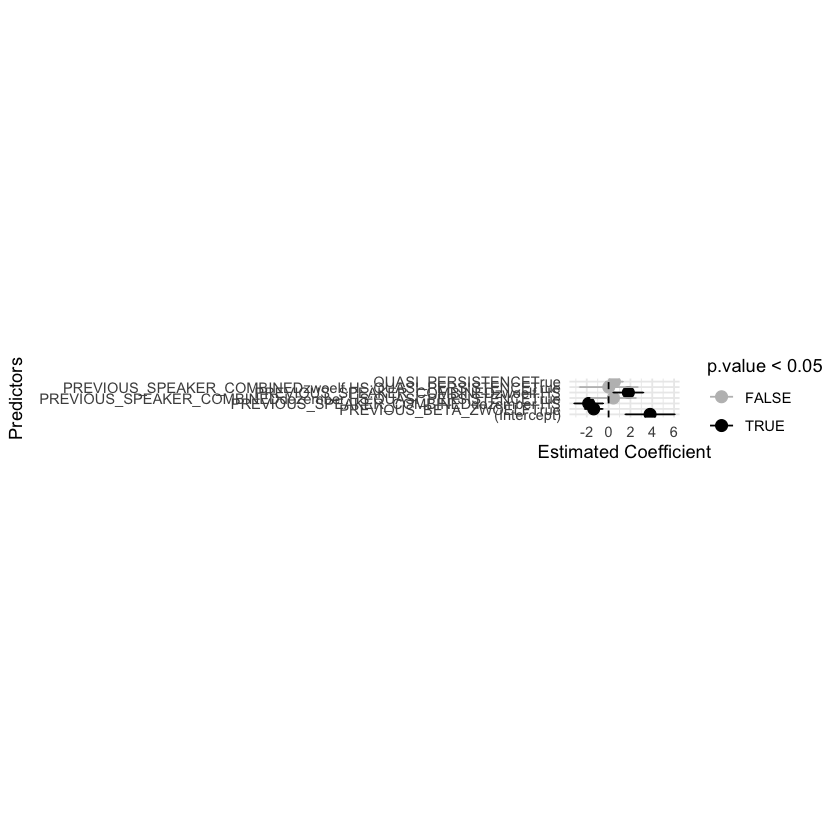

In [27]:
model_summary <- tidy(final_mixed_model, conf.int = TRUE) %>% filter(effect == "fixed")  #Include only fixed effects

plot <- ggplot(model_summary, aes(x = estimate, y = term, color = p.value < 0.05)) +
          geom_point(size = 3) +
          geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +  
          geom_vline(xintercept = 0, linetype = "dashed") +
          labs(
            x = "Estimated Coefficient",
            y = "Predictors",
          ) +
          theme_minimal() +
          scale_color_manual(values = c("TRUE" = "black", "FALSE" = "gray")) +  #Grey out non-significant predictors
          coord_fixed(ratio = 0.5)

plot

#### Prediction Plot

Plot visualises the probability of observing "zwoelf" in CURRENT given different combinations of variants in PREVIOUS and SPEAKERS.

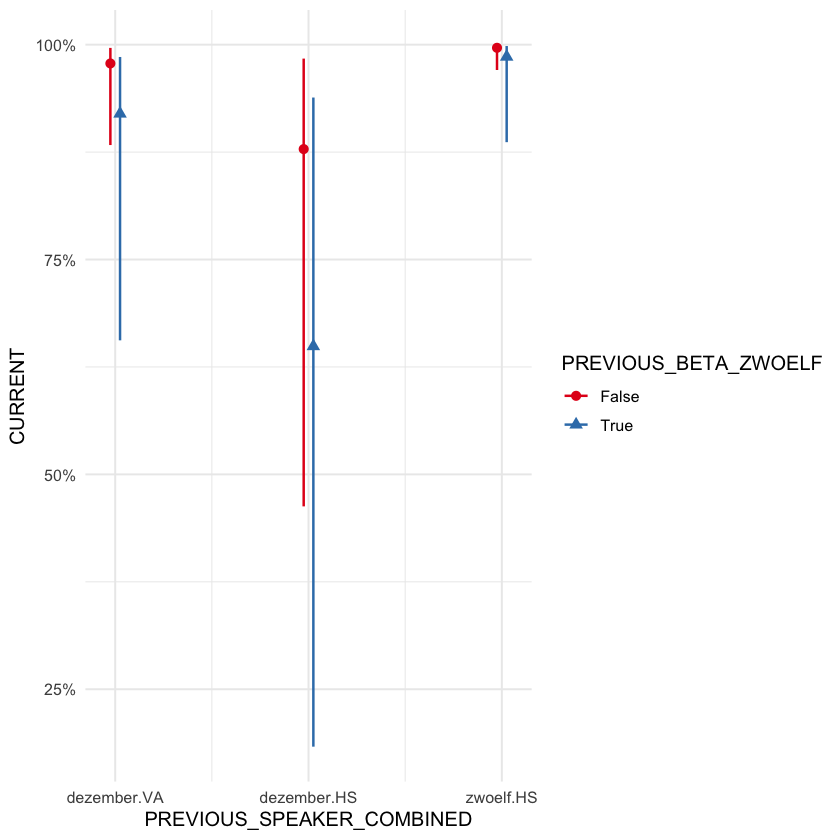

In [28]:
#for "zwölf" in CURRENT
plot <- plot_model(final_mixed_model, type = "pred", 
                   terms = c("PREVIOUS_SPEAKER_COMBINED", "PREVIOUS_BETA_ZWOELF"), 
                   group = "HUMAN_ID", dpi = 300)

plot <- plot +
    aes(color = as.factor(group), shape = as.factor(group)) +
    scale_shape_manual(values = c(16, 17)) +
    guides(color = guide_legend(title = "PREVIOUS_BETA_ZWOELF"),
    shape = guide_legend(title = "PREVIOUS_BETA_ZWOELF")) +
    theme_minimal(base_size = 12) +
    theme(plot.title = element_blank(),
          legend.position = "right")

plot